# Task 3

In this task, we train two models on a self-chosen set of images. This code is based on code from the given jupyter notebook. We modified the code of this notebook where necessary for the given assignment. 

In [6]:
import keras
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.datasets import fashion_mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2DTranspose, Reshape, Conv2D, MaxPooling2D
from keras import backend as K
from functools import partial
from sklearn.model_selection import train_test_split
import numpy as np

## Importing data (needs to be a different self-chosen dataset)

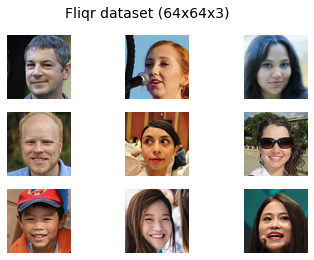

In [2]:
def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues, you can  change this value
    X = np.load('face_dataset_64x64.npy')[:20000, :, :, :]
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'resultstask3/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='Fliqr dataset (64x64x3)', n=3)

## General functions

In [4]:
def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images. 
    """

    model = Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim)) 
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

## Building and training models

### VAE

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                3

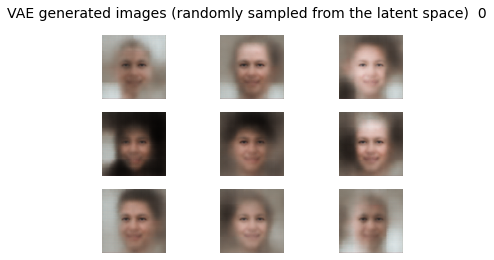

  80/2500 [..............................] - ETA: 4:30 - loss: 0.6007

KeyboardInterrupt: 

In [8]:
latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    latent_vectors = np.random.randn(9, latent_dim)
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8)
    
    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

### GAN

In [ ]:
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN

In [10]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              263168    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 128)        73856     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 128)      147584    
 ranspose)                                                       
                                                      

  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

1/1 [==============================] - 0s 371ms/step


  1%|▌                                                                                 | 1/156 [00:03<08:22,  3.24s/it]

1/1 [==============================] - 0s 201ms/step


  1%|█                                                                                 | 2/156 [00:04<05:48,  2.26s/it]

1/1 [==============================] - 0s 188ms/step


  2%|█▌                                                                                | 3/156 [00:06<04:55,  1.93s/it]

1/1 [==============================] - 0s 209ms/step


  3%|██                                                                                | 4/156 [00:07<04:30,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


  3%|██▋                                                                               | 5/156 [00:09<04:20,  1.72s/it]

1/1 [==============================] - 0s 214ms/step


  4%|███▏                                                                              | 6/156 [00:11<04:12,  1.68s/it]

1/1 [==============================] - 0s 184ms/step


  4%|███▋                                                                              | 7/156 [00:12<04:04,  1.64s/it]

1/1 [==============================] - 0s 190ms/step


  5%|████▏                                                                             | 8/156 [00:14<03:58,  1.61s/it]

1/1 [==============================] - 0s 184ms/step


  6%|████▋                                                                             | 9/156 [00:15<03:53,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


  6%|█████▏                                                                           | 10/156 [00:17<03:51,  1.59s/it]

1/1 [==============================] - 0s 208ms/step


  7%|█████▋                                                                           | 11/156 [00:18<03:48,  1.57s/it]

1/1 [==============================] - 0s 248ms/step


  8%|██████▏                                                                          | 12/156 [00:20<03:52,  1.61s/it]

1/1 [==============================] - 0s 185ms/step


  8%|██████▊                                                                          | 13/156 [00:22<03:47,  1.59s/it]

1/1 [==============================] - 0s 184ms/step


  9%|███████▎                                                                         | 14/156 [00:23<03:44,  1.58s/it]

1/1 [==============================] - 0s 193ms/step


 10%|███████▊                                                                         | 15/156 [00:25<03:42,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 10%|████████▎                                                                        | 16/156 [00:26<03:39,  1.57s/it]

1/1 [==============================] - 0s 194ms/step


 11%|████████▊                                                                        | 17/156 [00:28<03:39,  1.58s/it]

1/1 [==============================] - 0s 206ms/step


 12%|█████████▎                                                                       | 18/156 [00:30<03:39,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


 12%|█████████▊                                                                       | 19/156 [00:31<03:38,  1.59s/it]

1/1 [==============================] - 0s 194ms/step


 13%|██████████▍                                                                      | 20/156 [00:33<03:35,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 13%|██████████▉                                                                      | 21/156 [00:34<03:33,  1.58s/it]

1/1 [==============================] - 0s 191ms/step


 14%|███████████▍                                                                     | 22/156 [00:36<03:31,  1.58s/it]

1/1 [==============================] - 0s 216ms/step


 15%|███████████▉                                                                     | 23/156 [00:38<03:32,  1.60s/it]

1/1 [==============================] - 0s 232ms/step


 15%|████████████▍                                                                    | 24/156 [00:39<03:42,  1.69s/it]

1/1 [==============================] - 0s 234ms/step


 16%|████████████▉                                                                    | 25/156 [00:41<03:51,  1.77s/it]

1/1 [==============================] - 0s 236ms/step


 17%|█████████████▌                                                                   | 26/156 [00:43<03:58,  1.84s/it]

1/1 [==============================] - 0s 237ms/step


 17%|██████████████                                                                   | 27/156 [00:45<03:53,  1.81s/it]

1/1 [==============================] - 0s 210ms/step


 18%|██████████████▌                                                                  | 28/156 [00:47<03:44,  1.75s/it]

1/1 [==============================] - 0s 208ms/step


 19%|███████████████                                                                  | 29/156 [00:48<03:36,  1.70s/it]

1/1 [==============================] - 0s 196ms/step


 19%|███████████████▌                                                                 | 30/156 [00:50<03:29,  1.67s/it]

1/1 [==============================] - 0s 200ms/step


 20%|████████████████                                                                 | 31/156 [00:51<03:26,  1.65s/it]

1/1 [==============================] - 0s 192ms/step


 21%|████████████████▌                                                                | 32/156 [00:53<03:23,  1.64s/it]

1/1 [==============================] - 0s 204ms/step


 21%|█████████████████▏                                                               | 33/156 [00:55<03:20,  1.63s/it]

1/1 [==============================] - 0s 200ms/step


 22%|█████████████████▋                                                               | 34/156 [00:56<03:16,  1.61s/it]

1/1 [==============================] - 0s 200ms/step


 22%|██████████████████▏                                                              | 35/156 [00:58<03:13,  1.60s/it]

1/1 [==============================] - 0s 197ms/step


 23%|██████████████████▋                                                              | 36/156 [00:59<03:10,  1.59s/it]

1/1 [==============================] - 0s 194ms/step


 24%|███████████████████▏                                                             | 37/156 [01:01<03:08,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


 24%|███████████████████▋                                                             | 38/156 [01:03<03:07,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


 25%|████████████████████▎                                                            | 39/156 [01:04<03:07,  1.61s/it]

1/1 [==============================] - 0s 195ms/step


 26%|████████████████████▊                                                            | 40/156 [01:06<03:04,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


 26%|█████████████████████▎                                                           | 41/156 [01:07<03:02,  1.59s/it]

1/1 [==============================] - 0s 202ms/step


 27%|█████████████████████▊                                                           | 42/156 [01:09<02:59,  1.58s/it]

1/1 [==============================] - 0s 200ms/step


 28%|██████████████████████▎                                                          | 43/156 [01:11<02:58,  1.58s/it]

1/1 [==============================] - 0s 200ms/step


 28%|██████████████████████▊                                                          | 44/156 [01:12<02:59,  1.60s/it]

1/1 [==============================] - 0s 200ms/step


 29%|███████████████████████▎                                                         | 45/156 [01:14<02:56,  1.59s/it]

1/1 [==============================] - 0s 192ms/step


 29%|███████████████████████▉                                                         | 46/156 [01:15<02:55,  1.60s/it]

1/1 [==============================] - 0s 184ms/step


 30%|████████████████████████▍                                                        | 47/156 [01:17<02:51,  1.57s/it]

1/1 [==============================] - 0s 195ms/step


 31%|████████████████████████▉                                                        | 48/156 [01:18<02:50,  1.58s/it]

1/1 [==============================] - 0s 208ms/step


 31%|█████████████████████████▍                                                       | 49/156 [01:20<02:49,  1.58s/it]

1/1 [==============================] - 0s 216ms/step


 32%|█████████████████████████▉                                                       | 50/156 [01:22<02:47,  1.58s/it]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████▍                                                      | 51/156 [01:23<02:45,  1.57s/it]

1/1 [==============================] - 0s 192ms/step


 33%|███████████████████████████                                                      | 52/156 [01:25<02:42,  1.57s/it]

1/1 [==============================] - 0s 184ms/step


 34%|███████████████████████████▌                                                     | 53/156 [01:26<02:40,  1.55s/it]

1/1 [==============================] - 0s 194ms/step


 35%|████████████████████████████                                                     | 54/156 [01:28<02:37,  1.55s/it]

1/1 [==============================] - 0s 220ms/step


 35%|████████████████████████████▌                                                    | 55/156 [01:29<02:36,  1.55s/it]

1/1 [==============================] - 0s 185ms/step


 36%|█████████████████████████████                                                    | 56/156 [01:31<02:34,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 37%|█████████████████████████████▌                                                   | 57/156 [01:32<02:34,  1.56s/it]

1/1 [==============================] - 0s 281ms/step


 37%|██████████████████████████████                                                   | 58/156 [01:34<02:34,  1.57s/it]

1/1 [==============================] - 0s 184ms/step


 38%|██████████████████████████████▋                                                  | 59/156 [01:36<02:31,  1.56s/it]

1/1 [==============================] - 0s 185ms/step


 38%|███████████████████████████████▏                                                 | 60/156 [01:37<02:28,  1.55s/it]

1/1 [==============================] - 0s 179ms/step


 39%|███████████████████████████████▋                                                 | 61/156 [01:39<02:27,  1.55s/it]

1/1 [==============================] - 0s 185ms/step


 40%|████████████████████████████████▏                                                | 62/156 [01:40<02:25,  1.55s/it]

1/1 [==============================] - 0s 188ms/step


 40%|████████████████████████████████▋                                                | 63/156 [01:42<02:23,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 41%|█████████████████████████████████▏                                               | 64/156 [01:43<02:22,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 42%|█████████████████████████████████▊                                               | 65/156 [01:45<02:20,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


 42%|██████████████████████████████████▎                                              | 66/156 [01:46<02:18,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 43%|██████████████████████████████████▊                                              | 67/156 [01:48<02:17,  1.55s/it]

1/1 [==============================] - 0s 184ms/step


 44%|███████████████████████████████████▎                                             | 68/156 [01:49<02:15,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 44%|███████████████████████████████████▊                                             | 69/156 [01:51<02:13,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 45%|████████████████████████████████████▎                                            | 70/156 [01:53<02:12,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


 46%|████████████████████████████████████▊                                            | 71/156 [01:54<02:11,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 46%|█████████████████████████████████████▍                                           | 72/156 [01:56<02:08,  1.53s/it]

1/1 [==============================] - 0s 320ms/step


 47%|█████████████████████████████████████▉                                           | 73/156 [01:57<02:11,  1.58s/it]

1/1 [==============================] - 0s 185ms/step


 47%|██████████████████████████████████████▍                                          | 74/156 [01:59<02:08,  1.56s/it]

1/1 [==============================] - 0s 184ms/step


 48%|██████████████████████████████████████▉                                          | 75/156 [02:00<02:05,  1.55s/it]

1/1 [==============================] - 0s 182ms/step


 49%|███████████████████████████████████████▍                                         | 76/156 [02:02<02:03,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


 49%|███████████████████████████████████████▉                                         | 77/156 [02:03<02:01,  1.54s/it]

1/1 [==============================] - 0s 183ms/step


 50%|████████████████████████████████████████▌                                        | 78/156 [02:05<01:59,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 51%|█████████████████████████████████████████                                        | 79/156 [02:06<01:58,  1.53s/it]

1/1 [==============================] - 0s 192ms/step


 51%|█████████████████████████████████████████▌                                       | 80/156 [02:08<01:56,  1.53s/it]

1/1 [==============================] - 0s 191ms/step


 52%|██████████████████████████████████████████                                       | 81/156 [02:10<01:54,  1.53s/it]

1/1 [==============================] - 0s 184ms/step


 53%|██████████████████████████████████████████▌                                      | 82/156 [02:11<01:53,  1.53s/it]

1/1 [==============================] - 0s 184ms/step


 53%|███████████████████████████████████████████                                      | 83/156 [02:13<01:51,  1.53s/it]

1/1 [==============================] - 0s 184ms/step


 54%|███████████████████████████████████████████▌                                     | 84/156 [02:14<01:50,  1.53s/it]

1/1 [==============================] - 0s 192ms/step


 54%|████████████████████████████████████████████▏                                    | 85/156 [02:16<01:48,  1.52s/it]

1/1 [==============================] - 0s 192ms/step


 55%|████████████████████████████████████████████▋                                    | 86/156 [02:17<01:46,  1.52s/it]

1/1 [==============================] - 0s 192ms/step


 56%|█████████████████████████████████████████████▏                                   | 87/156 [02:19<01:45,  1.52s/it]

1/1 [==============================] - 0s 184ms/step


 56%|█████████████████████████████████████████████▋                                   | 88/156 [02:20<01:43,  1.52s/it]

1/1 [==============================] - 0s 184ms/step


 57%|██████████████████████████████████████████████▏                                  | 89/156 [02:22<01:41,  1.52s/it]

1/1 [==============================] - 0s 184ms/step


 58%|██████████████████████████████████████████████▋                                  | 90/156 [02:23<01:40,  1.53s/it]

1/1 [==============================] - 0s 192ms/step


 58%|███████████████████████████████████████████████▎                                 | 91/156 [02:25<01:39,  1.53s/it]

1/1 [==============================] - 0s 184ms/step


 59%|███████████████████████████████████████████████▊                                 | 92/156 [02:26<01:38,  1.53s/it]

1/1 [==============================] - 0s 192ms/step


 60%|████████████████████████████████████████████████▎                                | 93/156 [02:28<01:37,  1.54s/it]

1/1 [==============================] - 0s 200ms/step


 60%|████████████████████████████████████████████████▊                                | 94/156 [02:29<01:35,  1.55s/it]

1/1 [==============================] - 0s 200ms/step


 61%|█████████████████████████████████████████████████▎                               | 95/156 [02:31<01:35,  1.56s/it]

1/1 [==============================] - 0s 192ms/step


 62%|█████████████████████████████████████████████████▊                               | 96/156 [02:33<01:33,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 62%|██████████████████████████████████████████████████▎                              | 97/156 [02:34<01:32,  1.57s/it]

1/1 [==============================] - 0s 190ms/step


 63%|██████████████████████████████████████████████████▉                              | 98/156 [02:36<01:31,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 63%|███████████████████████████████████████████████████▍                             | 99/156 [02:37<01:29,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


 64%|███████████████████████████████████████████████████▎                            | 100/156 [02:39<01:28,  1.58s/it]

1/1 [==============================] - 0s 200ms/step


 65%|███████████████████████████████████████████████████▊                            | 101/156 [02:40<01:26,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 65%|████████████████████████████████████████████████████▎                           | 102/156 [02:42<01:24,  1.57s/it]

1/1 [==============================] - 0s 184ms/step


 66%|████████████████████████████████████████████████████▊                           | 103/156 [02:44<01:22,  1.56s/it]

1/1 [==============================] - 0s 192ms/step


 67%|█████████████████████████████████████████████████████▎                          | 104/156 [02:45<01:21,  1.57s/it]

1/1 [==============================] - 0s 190ms/step


 67%|█████████████████████████████████████████████████████▊                          | 105/156 [02:47<01:19,  1.57s/it]

1/1 [==============================] - 0s 194ms/step


 68%|██████████████████████████████████████████████████████▎                         | 106/156 [02:48<01:18,  1.57s/it]

1/1 [==============================] - 0s 196ms/step


 69%|██████████████████████████████████████████████████████▊                         | 107/156 [02:50<01:17,  1.57s/it]

1/1 [==============================] - 0s 192ms/step


 69%|███████████████████████████████████████████████████████▍                        | 108/156 [02:51<01:15,  1.57s/it]

1/1 [==============================] - 0s 192ms/step


 70%|███████████████████████████████████████████████████████▉                        | 109/156 [02:53<01:14,  1.57s/it]

1/1 [==============================] - 0s 200ms/step


 71%|████████████████████████████████████████████████████████▍                       | 110/156 [02:55<01:12,  1.57s/it]

1/1 [==============================] - 0s 208ms/step


 71%|████████████████████████████████████████████████████████▉                       | 111/156 [02:56<01:11,  1.58s/it]

1/1 [==============================] - 0s 188ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 112/156 [02:58<01:09,  1.57s/it]

1/1 [==============================] - 0s 193ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 113/156 [02:59<01:07,  1.58s/it]

1/1 [==============================] - 0s 182ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 114/156 [03:01<01:06,  1.59s/it]

1/1 [==============================] - 0s 210ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 115/156 [03:03<01:05,  1.59s/it]

1/1 [==============================] - 0s 192ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 116/156 [03:04<01:03,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 75%|████████████████████████████████████████████████████████████                    | 117/156 [03:06<01:01,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 118/156 [03:07<01:00,  1.58s/it]

1/1 [==============================] - 0s 195ms/step


 76%|█████████████████████████████████████████████████████████████                   | 119/156 [03:09<00:59,  1.60s/it]

1/1 [==============================] - 0s 200ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 120/156 [03:10<00:57,  1.59s/it]

1/1 [==============================] - 0s 195ms/step


 78%|██████████████████████████████████████████████████████████████                  | 121/156 [03:12<00:55,  1.60s/it]

1/1 [==============================] - 0s 184ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 122/156 [03:14<00:53,  1.58s/it]

1/1 [==============================] - 0s 184ms/step


 79%|███████████████████████████████████████████████████████████████                 | 123/156 [03:15<00:51,  1.57s/it]

1/1 [==============================] - 0s 184ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 124/156 [03:17<00:49,  1.56s/it]

1/1 [==============================] - 0s 187ms/step


 80%|████████████████████████████████████████████████████████████████                | 125/156 [03:18<00:48,  1.56s/it]

1/1 [==============================] - 0s 194ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 126/156 [03:20<00:46,  1.56s/it]

1/1 [==============================] - 0s 192ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 127/156 [03:21<00:45,  1.56s/it]

1/1 [==============================] - 0s 192ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 128/156 [03:23<00:43,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 129/156 [03:24<00:41,  1.55s/it]

1/1 [==============================] - 0s 190ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 130/156 [03:26<00:40,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 131/156 [03:28<00:38,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 132/156 [03:29<00:36,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 133/156 [03:31<00:35,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 134/156 [03:32<00:33,  1.54s/it]

1/1 [==============================] - 0s 184ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 135/156 [03:34<00:32,  1.54s/it]

1/1 [==============================] - 0s 190ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 136/156 [03:35<00:30,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 137/156 [03:37<00:30,  1.60s/it]

1/1 [==============================] - 0s 200ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 138/156 [03:39<00:29,  1.62s/it]

1/1 [==============================] - 0s 208ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 139/156 [03:40<00:27,  1.63s/it]

1/1 [==============================] - 0s 185ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 140/156 [03:42<00:25,  1.61s/it]

1/1 [==============================] - 0s 192ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 141/156 [03:43<00:23,  1.58s/it]

1/1 [==============================] - 0s 183ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 142/156 [03:45<00:21,  1.56s/it]

1/1 [==============================] - 0s 194ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 143/156 [03:46<00:20,  1.56s/it]

1/1 [==============================] - 0s 184ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 144/156 [03:48<00:18,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 145/156 [03:50<00:17,  1.56s/it]

1/1 [==============================] - 0s 192ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 146/156 [03:51<00:15,  1.56s/it]

1/1 [==============================] - 0s 185ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 147/156 [03:53<00:13,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 148/156 [03:54<00:12,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 149/156 [03:56<00:10,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 150/156 [03:57<00:09,  1.55s/it]

1/1 [==============================] - 0s 193ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 151/156 [03:59<00:07,  1.54s/it]

1/1 [==============================] - 0s 208ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 152/156 [04:00<00:06,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 153/156 [04:02<00:04,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 154/156 [04:04<00:03,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 155/156 [04:05<00:01,  1.57s/it]

1/1 [==============================] - 0s 184ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [04:07<00:00,  1.58s/it]


1/1 [==============================] - 0s 217ms/step


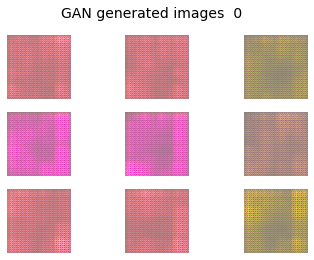

  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

1/1 [==============================] - 0s 184ms/step


  1%|▌                                                                                 | 1/156 [00:01<03:54,  1.52s/it]

1/1 [==============================] - 0s 184ms/step


  1%|█                                                                                 | 2/156 [00:03<03:54,  1.52s/it]

1/1 [==============================] - 0s 186ms/step


  2%|█▌                                                                                | 3/156 [00:04<03:52,  1.52s/it]

1/1 [==============================] - 0s 200ms/step


  3%|██                                                                                | 4/156 [00:06<03:52,  1.53s/it]

1/1 [==============================] - 0s 186ms/step


  3%|██▋                                                                               | 5/156 [00:07<03:49,  1.52s/it]

1/1 [==============================] - 0s 192ms/step


  4%|███▏                                                                              | 6/156 [00:09<03:51,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


  4%|███▋                                                                              | 7/156 [00:10<03:53,  1.57s/it]

1/1 [==============================] - 0s 216ms/step


  5%|████▏                                                                             | 8/156 [00:12<03:55,  1.59s/it]

1/1 [==============================] - 0s 190ms/step


  6%|████▋                                                                             | 9/156 [00:14<03:55,  1.60s/it]

1/1 [==============================] - 0s 211ms/step


  6%|█████▏                                                                           | 10/156 [00:15<03:52,  1.59s/it]

1/1 [==============================] - 0s 198ms/step


  6%|█████▏                                                                           | 10/156 [00:17<04:14,  1.75s/it]


KeyboardInterrupt: 

In [11]:
## Build and train the model (need around 10 epochs to start seeing some results)

latent_dim = 256
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=20)

## Generating novel images